<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Watershed DEM processing and de Almeida (2012) 2D flow routing tutorial 

In this tutorial we will show how to:
* read a watershed DEM
* identify the outlet of the DEM
* identify the main channel link to the outlet
* run the de Almeida 2D flood routing algorithm for a given effective rainfall (rate and duration) and surface roughness.

In [2]:
%matplotlib inline
from __future__ import print_function
import os
import time
import numpy as np
from landlab.plot.colors import water_colormap
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
from landlab.plot.imshow import imshow_node_grid, imshow_grid_at_cell
from matplotlib import pyplot as plt
from landlab.components.overland_flow import OverlandFlow

Read the DEM and plot elavations. The grid name is "mg" and it will hold elevations "z". You will notice that color of elevations won't plot properly because of low no data values of the DEM. We will now upload a 10-m pit-filled DEM of a small gully watershed in Colorado.

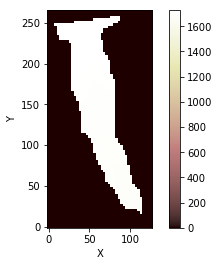

In [3]:
(rmg,z)=read_esri_ascii('west_bijou_gully_PF.asc', name='elevation')
imshow_grid(rmg, 'elevation')

Next we will set the watershed boundary condition and identify the outlet using the elevation field and its no data value. As you will see the no data value of the DEM is 0.0. Now we can plot the DEM which will show only the elevations within the watershed boundary.

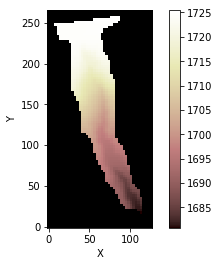

In [4]:
no_data=min(z)
rmg.set_watershed_boundary_condition(z,no_data)
imshow_grid(rmg, 'elevation')

Relevant for this exercise, status of the nodes are as follows:
Core: 0; Fixed value boundary: 1 (i.e., outlet); Closed boundary: 4. Status of our nodes can be plotted as:  

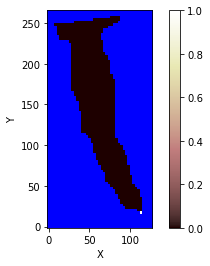

In [5]:
imshow_grid(rmg, rmg.status_at_node,color_for_closed='blue')

To route flow to the outlet in Landlab we need to identify the outlet of the watershed. The link that drains watershed to the outlet node can be used to plot storm runoff hydrograph. For this, the following steps can be followed. First identify the outlet node ID:

In [6]:
outlet_node = np.where(rmg.status_at_node==1)
outlet_node

(array([296], dtype=int64),)

Now find the links that are connected to the outlet node

In [7]:
rmg.links_at_node[296]

array([548, 590, 547, 505])

we can identify the active links for this node as:

In [8]:
rmg.status_at_link[rmg.links_at_node[296]]

array([4, 0, 4, 4])

Here we can see that link 590 is the link we should be using for routing flows to the outlet. Now let's check the direction of this active link with respect to node 296.

In [9]:
rmg.active_link_dirs_at_node[296]

array([ 0, -1,  0,  0], dtype=int8)

The link direction is [-1]. This indicates that the node connected to 296 through link 590 is located either N or E of node 296. Node that link direction here is not flow direction. This comes from numbering convention of nodes and links. In our case it should be located N of 296, see the node status map above. This would mean that link 590 would have a tail node of 296, and a head node much larger than 296 as node IDs grow toward N and E in Landlab. Let's check link head and tail nodes for 590:

In [10]:
rmg.node_at_link_head[590]

339

In [11]:
rmg.node_at_link_tail[590]

296

Let's check the gradients for these links below. The active link 590 has a positive and realistic gradient, pointing S. This clearly shows that 590 is the link we are looking for.

In [12]:
rmg.calc_grad_at_link(z)[rmg.links_at_node[296]]

array([ -5.60259797e+02,   2.08952727e-01,   5.60259797e+02,
         5.60259797e+02])

In what follows, we will use a driver which utilizes the OverlandFlow class from generate_overland_flow_deAlmeida.py to simulate a storm runoff hydrograph for a given duration and rate of effective rainfall (runoff) and surface roughness. This component is based on the model proposed by de Almeida et al. [2012]. If you want to use this driver separate from the DEM analysis above, please uncomment the lines in the first and second box below. These are commented out as DEM processing was done above. 

de Almeida, G. A. M., P. Bates, J. E. Freer, and M. Souvignet (2012), Improving the stability of a simple formulation of the shallow water equations for 2-D flood modeling, Water Resour. Res., 48, W05528, doi:10.1029/2011WR011570.

For quesitons contact: Adams, Jordan M <jadams15@tulane.edu>, Nicole Gasparini <ngaspari@tulane.edu> 

In [ ]:
# from __future__ import print_function
# %matplotlib inline
# import os
# import time
# import numpy as np
# from landlab.plot.colors import water_colormap
# from landlab.io import read_esri_ascii
# from landlab.plot import imshow_grid
# from landlab.plot.imshow import imshow_node_grid, imshow_grid_at_cell
# from matplotlib import pyplot as plt
# from landlab.components.overland_flow import OverlandFlow

In [ ]:
# (rmg, z) = read_esri_ascii('west_bijou_gully_PF.asc')
# rmg.set_watershed_boundary_condition(z,0)

In [13]:
# This provides us with an initial time. At the end, it gives us total
# model run time in seconds.
start_time = time.time()

some model input parameters

In [14]:
## Start time 1 second
elapsed_time = 1.0

model_run_time = 1.0     ## Model Run Time in hours
storm_duration = 0.25    ## Storm duration hours
runoff_intensity = 50    ## Runoff intensity (mm/h)
mannings_n=0.05          ## surface roughness 

Initialize fields and list data to save and plot

In [15]:
## Lists for saving data to plot storm runoff hydrograph 
discharge_at_outlet = []
hydrograph_time_sec = []
hydrograph_time_hrs = []
## Setting initial fields...
rmg['node']['topographic__elevation'] = z   ## this is a static field; water discharge and depth will change with time
rmg['link']['water__discharge'] = np.zeros(rmg.number_of_links) 
rmg['node']['water__depth'] = np.zeros(rmg.number_of_nodes)

Initialize the overland flow class, indicate the link to plot hydrograph 

In [16]:
## Initialize the OverlandFlow() class.
of = OverlandFlow(rmg, steep_slopes=True, mannings_n=mannings_n)
start_time = time.time() ## Record the start time so we know how long it runs.
link_to_sample = 590     ## Link to sample at the outlet to plot hydrograph
switch_plot_inter = 0    ## this is used to limit water depth plot to a single figure plotted at a specified time below.

This is the main loop of the overland flow routing solution that runs for the given model run time. This also plots water depths in the watershed at the peak time of the hydrograph. 

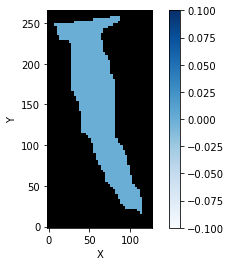

In [17]:
while elapsed_time < model_run_time*3600:
    
    ## The storm starts when the model starts. While the elapsed time is less
    ## than the storm duration, we add water to the system as rainfall.
    if elapsed_time < storm_duration*3600:

        of.rainfall_intensity = runoff_intensity* 2.777 * (10 ** -7) # Rainfall intensity (m/s)

    ## Then the elapsed time exceeds the storm duration, rainfall ceases.
    else:

        of.rainfall_intensity = 0.0

    ## Generating overland flow based on the deAlmeida solution.
    of.overland_flow()

    ## Append time and discharge to their lists to save data and for plotting.
    hydrograph_time_sec.append(elapsed_time)
    hydrograph_time_hrs.append(elapsed_time/3600.)
    discharge_at_outlet.append(of.q[link_to_sample])
    
     ## plot after elapsed_time=1080s-- this time is approximately when peak discharge is attained in the watershed you can adjust this value  
    if elapsed_time > 1080 and switch_plot_inter == 0:
        plt.figure(1)
        imshow_grid(rmg, 'water__depth', cmap='Blues')
        switch_plot_inter = 1

   ## Add the time step, repeat until elapsed time >= model_run_time
   # print(elapsed_time)  # uncomment this to print time.
    elapsed_time += of.dt

Here is the hydrograph

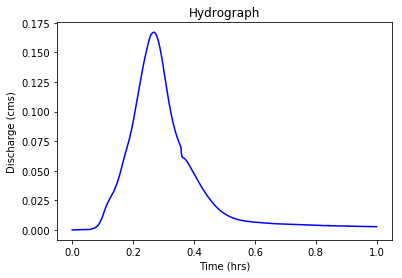

In [18]:
plt.figure(2)
plt.plot(hydrograph_time_hrs, (np.abs(discharge_at_outlet)*rmg.dx), 'b-')
plt.xlabel('Time (hrs)')
plt.ylabel('Discharge (cms)')
plt.title('Hydrograph')

In [19]:
endtime = time.time()
print('\n', 'Total run time: ', round(endtime - start_time, 2), ' seconds')


 Total run time:  21.36  seconds
